# 17.3 Metryki 

#### Import niezbednych bibliotek i paczek

In [1]:
import numpy as np
import pandas as pd
import string
import nltk
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\piotr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piotr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\piotr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Definicje wszystkich funkcji

In [2]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
def tokenize(text):
    # Usunięcie wielkich liter
    clean_text = text.lower()
    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words

#### Import pliku z danymi i jego formatowanie

In [3]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])

C:\Users\piotr\AppData\Local\Temp\ipykernel_21252\1552169415.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])


#### Obróbka danych - czyszczenie, tokenizacja, usuwanie stop words, Stemming, Lametyzcja

In [4]:
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))
spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))
stopwords = nltk.corpus.stopwords.words("english")
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))
stemmer = nltk.PorterStemmer()
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))
lemmater = nltk.WordNetLemmatizer()
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))

#### Rozdzielenie na X, y

In [5]:
X = spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x))
y = spam_dataset['Spam']

#### Rozdzielenie danych na zbiory treningowe oraz testowe

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Zdefiniowanie funkcji któraprzy podanym wektoryzerze i danych X, y zwróci informacje na teamt metryki i stworzy confusion matrix

In [7]:
def all_in_one(vectorizer, X_train, X_test, y_train, y_test):
    vector = vectorizer
    X_train_trans = vector.fit_transform(X_train)
    X_test_trans = vector.transform(X_test)
    clf = RandomForestClassifier()
    clf.fit(X_train_trans, y_train)
    print("Wartość Score dla Random Forest przy", str(vector).replace('()', ''), ":", clf.score(X_test_trans, y_test), "\n")
    print(".........Określam cechy ważniejsze niż 0.001 dla Random Forest..........\n")
    important_features = (np.where(clf.feature_importances_ > 0.001))[0].tolist()
    X_train_imp = X_train_trans[:,important_features]
    X_test_imp = X_test_trans[:,important_features]
    print(".........Wyszukuję najlepszych parametrów Random Forest za pomocą Grid Search (cechy ważniejsze niż 0.001)..............\n")
    random_forest = RandomForestClassifier( n_jobs=-1)
    params_rf = {'max_depth': [ None, 15],
                 'min_samples_leaf': [1, 3],
                 'n_estimators': [ 50, 100, 150 ],
                 'min_samples_split': [2, 3, 5]}
    rf_gridsearch = GridSearchCV(random_forest,
                                 params_rf,
                                 scoring='f1_micro',
                                 cv=5,
                                 verbose=10, n_jobs=-1)
    rf_gridsearch.fit(X_train_imp, y_train)
    print('\n.........Najlepsze Hiperparametry to:', rf_gridsearch.best_params_, ".........\n")
    model = rf_gridsearch.best_estimator_
    model.fit(X_train_imp, y_train)
    print(".........Score dla Grid Search (RandomForestClassifier) dla", str(vector).replace('()', ''), "przy najlepszych hiperpatametrach to:" ,model.score(X_test_imp, y_test), "\n")
    y_test_predict = model.predict(X_test_imp)
    print(".........Pełny raport dla tego modelu poniżej.............\n")
    print(classification_report(y_test, y_test_predict ),"\n\n")
    plt.figure()
    cm = confusion_matrix(y_test, y_test_predict)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

Wartość Score dla Random Forest przy TfidfVectorizer : 0.9730941704035875 

.........Określam cechy ważniejsze niż 0.001 dla Random Forest..........

.........Wyszukuję najlepszych parametrów Random Forest za pomocą Grid Search (cechy ważniejsze niż 0.001)..............

Fitting 5 folds for each of 36 candidates, totalling 180 fits

.........Najlepsze Hiperparametry to: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50} .........

.........Score dla Grid Search (RandomForestClassifier) dla TfidfVectorizer przy najlepszych hiperpatametrach to: 0.979372197309417 

.........Pełny raport dla tego modelu poniżej.............

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.97      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115
 




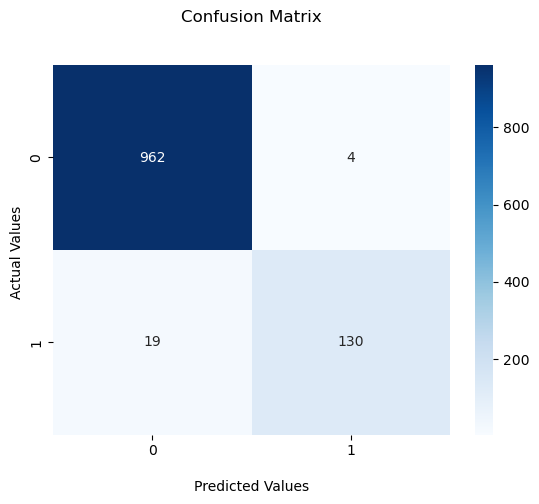






Wartość Score dla Random Forest przy CountVectorizer : 0.9721973094170404 

.........Określam cechy ważniejsze niż 0.001 dla Random Forest..........

.........Wyszukuję najlepszych parametrów Random Forest za pomocą Grid Search (cechy ważniejsze niż 0.001)..............

Fitting 5 folds for each of 36 candidates, totalling 180 fits

.........Najlepsze Hiperparametry to: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100} .........

.........Score dla Grid Search (RandomForestClassifier) dla CountVectorizer przy najlepszych hiperpatametrach to: 0.9775784753363229 

.........Pełny raport dla tego modelu poniżej.............

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115
 


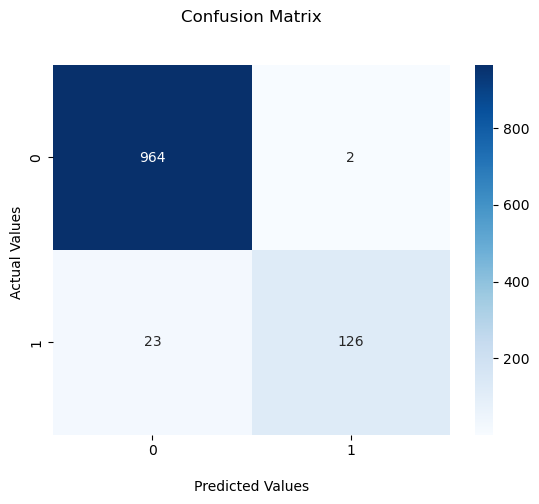

In [8]:
all_in_one(TfidfVectorizer(), X_train, X_test, y_train, y_test)
print("\n\n\n\n")
all_in_one(CountVectorizer(), X_train, X_test, y_train, y_test)